### By: Justin Cheigh
---
- [GitHub](https://github.com/jcheigh)
- [LinkedIn](https://www.linkedin.com/in/justin-cheigh/)
- [Medium (blog)](https://medium.com/@jcheigh)
---

In [3]:
import os 
import time
import random

from abc import ABC, abstractmethod, abstractproperty
from collections import defaultdict
from tqdm import tqdm 
from PIL import Image

import wandb 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import accuracy_score 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from timm import create_model

import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [4]:
libraries = [
    "numpy", 
    "pandas", 
    "sklearn", 
    "torch", 
    "wandb",
    "lightning"
    ]

versions = [
    np.__version__, 
    pd.__version__,
    sklearn.__version__,
    torch.__version__,
    wandb.__version__,
    pl.__version__
    ]


for lib, ver in zip(libraries, versions):
    print(f"{lib} {ver}")
!python --version

numpy 1.23.5
pandas 1.5.3
sklearn 1.2.2
torch 2.0.0
wandb 0.15.5
lightning 2.0.8
Python 3.10.12


In [5]:
def timeit(func):
    "decorator to time functions"
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"{func.__name__} executed in {elapsed_time:.3f} seconds")
        return result
    return wrapper

In [6]:
INPUT_PATH  = os.path.join('/kaggle', 'input')  # to read
OUTPUT_PATH = os.path.join('/kaggle', 'output') # to write

for path in os.listdir(INPUT_PATH):
    print(path)

rsna-2023-abdominal-trauma-detection
rsna-atd-512x512-png-v2-dataset


We have two input folders here. rsna-2023-abdominal-trauma-detection was the original data; the problem is that the images are in .dcm format. rsna-atd-512x512-png-v2-dataset was created in [this notebook](https://www.kaggle.com/code/awsaf49/rsna-atd-512x512-png-v2-data/notebook). The general idea is to merge the image_levels_labels.csv dataframe and the train.csv dataframe (creating a dataframe with a row for each image) and then use [this notebook](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs) to convert the images to .png format. 

In [7]:
DICOM_DATA  = 'rsna-2023-abdominal-trauma-detection'
PNG_DATA    = 'rsna-atd-512x512-png-v2-dataset'

for path in os.listdir(f"{INPUT_PATH}/{PNG_DATA}"):
    print(path)

sample_submission.csv
train_series_meta.csv
train_images
train.csv
test.csv
test_series_meta.csv
test_images


Let's look at train.csv first

In [8]:
df = pd.read_csv(f"{INPUT_PATH}/{PNG_DATA}/train.csv")
df = df.drop_duplicates()
df = df.drop(["series_id", "instance_number"], axis = 1)

def get_img_path(path):
    path = path.replace('.dcm', '.png')
    return path.replace(DICOM_DATA, PNG_DATA)

df["image_path"] = df["image_path"].apply(lambda path : get_img_path(path))

train.csv contains target labels for the train set. Note that patients labeled healthy may still have other medical issues, such as cancer or broken bones, that don't happen to be covered by the competition labels.

Column Description: <br>
- patient_id: A unique ID code for each patient
- (bowel/extravasation)_(healthy/injury): two injury types with binary targets
- (kidney/liver/spleen)_(healthy/low/high): -three injury types with three target levels
- any_injury: whether patient had any injury at all
- injury_name: name of injury
- image_path: path to .png of ct scan
- width/height: width/height of .png


Auto EDA with dataprep

!pip install dataprep <br>
from dataprep.eda import create_report <br>
create_report(df)

Basically just showed there's some class imbalance with multiclass labels


The following block of code is straight from [this notebook.](https://www.kaggle.com/code/ayushs9020/understanding-the-competition-rsna)

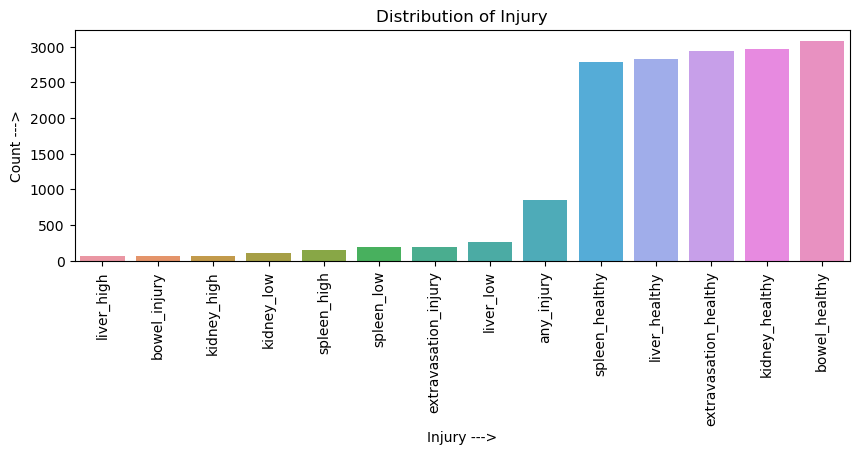

In [9]:
train_csv = pd.read_csv(f"{INPUT_PATH}/{DICOM_DATA}/train.csv")
organ_columns = ['bowel', 'extravasation', 'kidney', 'liver', 'spleen']

organ_counts = pd.DataFrame()
organ_counts['Organ'] = train_csv.columns[1:]
organ_counts["count"] = [0 for _ in range(organ_counts.shape[0])]
for index , column in enumerate(train_csv.columns[1:]):
    organ_counts['count'][index] = train_csv[column].sum()
    
plt.figure(figsize=(10, 3))
sns.barplot(data=organ_counts.sort_values(by=['count']), x='Organ', y='count')
plt.xticks(rotation=90)
plt.title("Distribution of Injury")
plt.xlabel("Injury --->")
plt.ylabel("Count --->")
plt.show()


In [10]:
### Weights & Biases Login 
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key      = user_secrets.get_secret("WANDB")

    wandb.login(key=api_key)
    del api_key
except:
    raise Exception("Your API key must remain anonymous")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {'GPU' if 'cuda' in str(device) else 'CPU'}")

Using GPU


In [12]:
class Config:
    COMPETITION   = 'rsna-atd' 
    COMMENT       = 'Base ResNet18'
    EXP_NAME      = "baseline: ResNet18 + multihead"   
    
    DEVICE        = "CPU" if device.type == 'cpu' else "GPU"   
    MODEL_NAME    = "ResNet18"
    
    SEED          = 42                   
    NUM_FOLDS     = 4           
    IMG_SIZE      = (256, 256)  
    BATCH_SIZE    = 64          
    EPOCHS        = 10 
    NUM_WORKERS   =  2
    TEST_SIZE     = .1
    PIN_MEMORY    = True  
    LOSS          = "Cross Entropy"
    OPTIMIZER     = "SGD"
    SCHEDULER     = "StepLR"
    
    TARGET_COLS   = [
                    "bowel_injury", "extravasation_injury",
                    "kidney_healthy", "kidney_low", "kidney_high",
                    "liver_healthy", "liver_low", "liver_high",
                    "spleen_healthy", "spleen_low", "spleen_high",
                    ]

In [13]:
def set_seed(seed=Config.SEED):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

set_seed()

In [14]:
class Data(Dataset):
    "Basic custom data class"
    
    def __init__(self, img_paths, labels, transform):
        self.paths     = img_paths
        self.labels    = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image    = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        label    = self.labels[idx]
        labels   = (
            label[0:1], # bowel
            label[1:2], # extravasation
            label[2:5], # kidney
            label[5:8], # liver
            label[8:11] # spleen
            )
        
        return image, labels

In [15]:
def get_transform(phase):
    "Returns list of transforms based on phase (train/test)"
    if phase == 'train':
        transform_lst = [
            transforms.RandomHorizontalFlip(p=.25),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            ]
    else:
        transform_lst = []
    
    transform_lst += [
            transforms.Resize(size=Config.IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.445], [0.269])  
            ]
    
    transform  = transforms.Compose(transform_lst)
    return transform

def get_dataloader(dataframe, phase='train'):
    paths     = dataframe.image_path.to_list()
    labels    = dataframe[Config.TARGET_COLS].values
    transform = get_transform(phase)
    data      = Data(
                    img_paths   = paths, 
                    labels      = labels,
                    transform   = transform
                    )
    
    return DataLoader(
                dataset     = data,
                batch_size  = Config.BATCH_SIZE,
                shuffle     = True,
                num_workers = Config.NUM_WORKERS,
                pin_memory  = Config.PIN_MEMORY,
                )

In [16]:
def stratify(df=df, num_folds=Config.NUM_FOLDS):
    """
    Adds new col df["fold"] that's the group for that row
    
    We use stra
    """
    df['stratify'] = ''
    for col in Config.TARGET_COLS:
        df['stratify'] += df[col].astype(str)

    df  = df.reset_index(drop=True)
    skf = StratifiedGroupKFold(
                n_splits     = num_folds, 
                shuffle      = True,
                random_state = Config.SEED
                )

    for fold, (train_idxs, val_idxs) in enumerate(skf.split(df, df['stratify'], df["patient_id"])):
        df.loc[val_idxs, 'fold'] = fold

    return df

def kfold_iter(df, k=Config.NUM_FOLDS):
    """
    Returns an iterator of train, test dataloaders for kfold validation
    
    Usage:
        dl_iter = kfold_iter(df, k)

        for _ range(k):
            train_dl, test_dl = next(dl_iter)
            ...
    
    Use an iterator for memory reasons
    """
    
    df = stratify(df, k)

    def get_dataloaders(df, test_grp):
        train = df[df['fold']  != test_grp]
        test  = df[df['fold']  == test_grp]

        train_dl   = get_dataloader(train, phase='train')
        test_dl    = get_dataloader(test, phase='test')

        return train_dl, test_dl
    
    return iter((get_dataloaders(df, i) for i in range(k)))


In [17]:
dl_iter = kfold_iter(df)
train_dl, test_dl = next(dl_iter)

images, labels = next(iter(train_dl))
# B x C x H x W = 64 x 1 x 256 x 256
print(f"Image Shape: {images.shape}\n")
print(f'Label Shape:')

for label in labels:
    print(label.shape)

Image Shape: torch.Size([64, 1, 256, 256])

Label Shape:
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 3])
torch.Size([64, 3])
torch.Size([64, 3])


Images is a batch of images, where each image has 1 color channel and has image size 256x256. Thus, images is a tensor with shape B x C x H x W = 64 x 1 x 256 x 256. Each individual label is a list of 1 dimensional tensors (binary for extra/bowel and 3 outputs otherwise). Thus, labels is a list of 5 tensors.

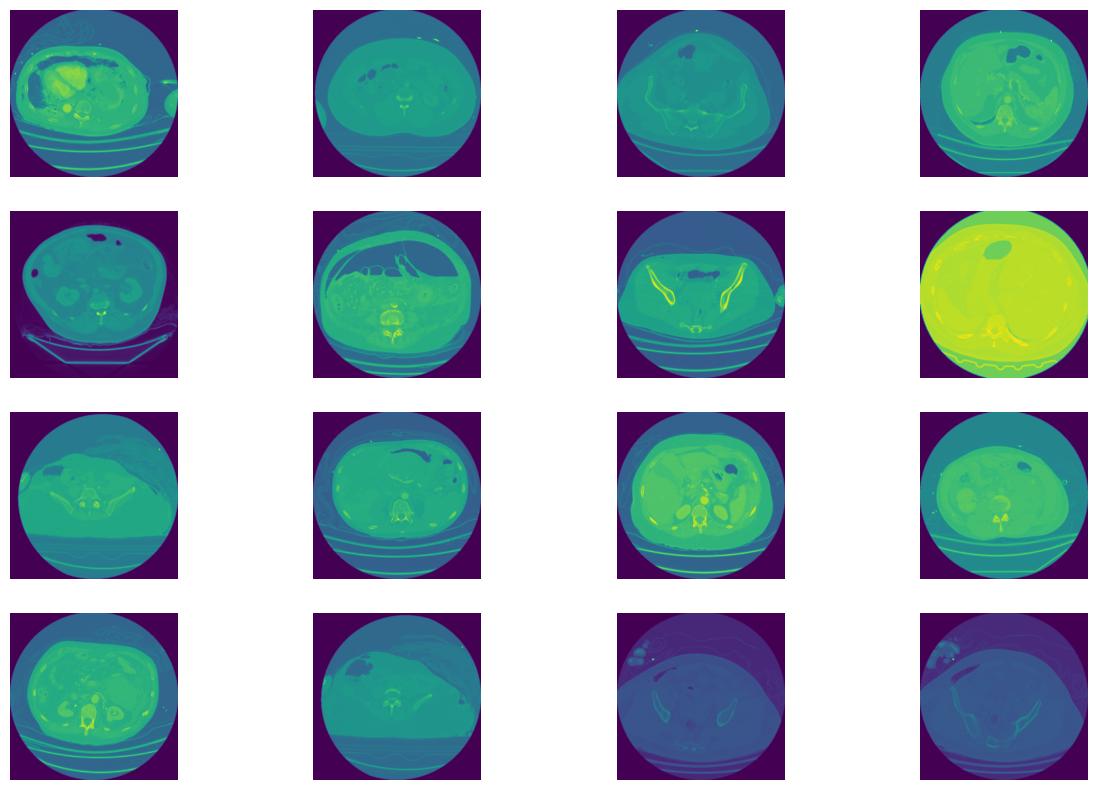

In [18]:
def plot_imgs(images, size=4):
    fig, axis = plt.subplots(4, 4, figsize = (15, 10))
    for i, ax in enumerate(axis.flat):
        with torch.no_grad():
            img = images[i].numpy()
            img = np.transpose(img, (1, 2, 0)) # torch/numpy convention
            ax.imshow(img)
            ax.axis('off')
            
plot_imgs(images)

In [25]:
class LitMultiHeadModel(pl.LightningModule, ABC): 
    """
    General MultiHeadedModel
    
    Forward pass involves passing though main layers 
    (self.backbone) and then using Global Average 
    Pooling (i.e. get activation maps) then dense 
    layers to 5 different heads.
    
    To Fill Out:
        self.define_backbone() should return a nn.Sequential
        self.hidden_dim specifies the output dim of self.backbone
    """

    def __init__(self):
        super().__init__()    
        self.train_log = defaultdict(float)
        self.val_log   = defaultdict(float)
        self.backbone  = self.define_backbone()
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Break into 5 heads 
        self.fc_bowel  = nn.Linear(self.hidden_dim, 32)
        self.fc_extra  = nn.Linear(self.hidden_dim, 32)
        self.fc_liver  = nn.Linear(self.hidden_dim, 32)
        self.fc_kidney = nn.Linear(self.hidden_dim, 32)
        self.fc_spleen = nn.Linear(self.hidden_dim, 32)
        
        # Prediction heads 
        self.out_bowel  = nn.Linear(32, 1)
        self.out_extra  = nn.Linear(32, 1)
        self.out_liver  = nn.Linear(32, 3)
        self.out_kidney = nn.Linear(32, 3)
        self.out_spleen = nn.Linear(32, 3)       
    
    @abstractmethod
    def define_backbone(self) -> nn.Sequential:
        raise NotImplementedError
    
    @abstractproperty
    def hidden_dim(self) -> int:
        raise NotImplementedError

    def init_wandb(self, fold):
        return None
        config = {var : val for var, val in dict(vars(Config)).items() if '__' not in var}
        config |= {"fold" : int(fold)} # use .update if python isn't new enough
        run    = wandb.init(
                    project   = "rsna-atd-public",
                    name      = f"fold-{fold}|dim-{Config.IMG_SIZE[0]}x{Config.IMG_SIZE[1]}|model-{Config.MODEL_NAME}",
                    config    = config,
                    anonymous = None,
                    group     = Config.EXP_NAME
                    )
        return run
    
    def criterion(self, outputs, labels, method="cross entropy"):
        if method == 'cross entropy':
            # define loss for each head- for now just sum of BCE & CCE
            loss_fn_bowel  = nn.BCELoss()           
            loss_fn_extra  = nn.BCELoss()
            loss_fn_liver  = nn.CrossEntropyLoss()
            loss_fn_kidney = nn.CrossEntropyLoss()
            loss_fn_spleen = nn.CrossEntropyLoss()

            labels = [label.float() for label in labels]

            # compute loss for each head
            loss_bowel  = loss_fn_bowel(outputs[0], labels[0])
            loss_extra  = loss_fn_extra(outputs[1], labels[1])
            loss_liver  = loss_fn_liver(outputs[2], labels[2])
            loss_kidney = loss_fn_kidney(outputs[3], labels[3])
            loss_spleen = loss_fn_spleen(outputs[4], labels[4])

            return loss_bowel + loss_extra + loss_liver + loss_kidney + loss_spleen
        
        elif method == 'weighted cross entropy':
            raise NotImplementedError
            
        raise NotImplementedError 

    def update_acc_log(self, outputs, labels, phase):
        if phase == "Train":
            acc_log = self.train_log
        else:
            acc_log = self.val_log
            
        get_preds  = lambda i: (outputs[i] > .5).float().squeeze().cpu().numpy()
        get_labels = lambda i: labels[i].squeeze().cpu().numpy()

        acc_log[f"{phase} Bowel Accuracy"]  += accuracy_score(get_preds(0), get_labels(0))
        acc_log[f"{phase} Extra Accuracy"]  += accuracy_score(get_preds(1), get_labels(1)) 
        acc_log[f"{phase} Liver Accuracy"]  += accuracy_score(get_preds(2), get_labels(2))
        acc_log[f"{phase} Kidney Accuracy"] += accuracy_score(get_preds(3), get_labels(3))
        acc_log[f"{phase} Spleen Accuracy"] += accuracy_score(get_preds(4), get_labels(4))
        acc_log[f"{phase} Avg. Accuracy"]   += round(np.mean(list(acc_log.values())), 3)
        
        return acc_log

    def show_stats(self, train_dl, val_dl):
        def show(phase):
            if phase == "Train":
                acc_log  = self.train_log
                data_len = len(train_dl)
            else:
                acc_log  = self.val_log 
                data_len = len(val_dl)
            
            to_acc = lambda total_acc : round(float((total_acc / data_len * 100), 3))
            log    = {head : to_acc(acc) for head, acc in acc_log.items()}
                                              
            print('-' * 20)
            for head, accuracy in log.items():
                print(f"{head}: {accuracy}")
            print('-' * 20)
            
            #wandb.log(log) 
                                              
        print(f"Train Stats:")
        show("Train")
        print(f"Validation Stats:")
        show("Val")
        
    def finish_run(self):
        wandb.finish()
        
    def forward(self, x):
        # Backbone + GAP
        x = self.backbone(x)
        x = self.global_avg_pool(x)              
        x = x.view(x.size(0), -1)              
        
        # Split into 5 Heads
        # SiLU is ReLU * x is slower but better convergence/stability
        x_bowel  = nn.SiLU()(self.fc_bowel(x)) 
        x_extra  = nn.SiLU()(self.fc_extra(x))
        x_liver  = nn.SiLU()(self.fc_liver(x))
        x_kidney = nn.SiLU()(self.fc_kidney(x))
        x_spleen = nn.SiLU()(self.fc_spleen(x))
        
        # Prediction heads
        out_bowel  = torch.sigmoid(self.out_bowel(x_bowel))
        out_extra  = torch.sigmoid(self.out_extra(x_extra))
        out_liver  = nn.Softmax(dim=1)(self.out_liver(x_liver))
        out_kidney = nn.Softmax(dim=1)(self.out_kidney(x_kidney))
        out_spleen = nn.Softmax(dim=1)(self.out_spleen(x_spleen))
        
        return [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    def training_step(self, batch, batch_idx):
        x, y    = batch
        y_hat   = self(x)
        loss    = self.criterion(y_hat, y)
        acc_log = self.update_acc_log(y_hat, y, "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the val loop
        x, y    = batch
        y_hat   = self(x)
        loss    = self.criterion(y_hat, y)
        acc_log = self.update_acc_log(y_hat, y, "Val")
        return loss 
    
    def configure_optimizers(self):
        def get_optimizer():
            if Config.OPTIMIZER == "Adam":
                return optim.Adam(self.parameters(), lr=1e-4)
            
            elif Config.OPTIMIZER == "SGD":
                return optim.SGD(self.parameters(), lr=0.001, momentum=0.9)

            raise NotImplementedError
            
        def get_scheduler(optimizer):
            if Config.SCHEDULER == "StepLR":
                return lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            
            raise NotImplementedError
                
        optimizer = get_optimizer()
        scheduler = get_scheduler(optimizer)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [26]:
class BasicCNN(LitMultiHeadModel):
    """
    Basic Convolutional Neural Network
        2 stacks of conv to relu to max pool
        1 final conv layer
        then multihead model
    """
    
    hidden_dim = 64
    
    def define_backbone(self):
        
        def create_conv(in_channels, out_channels):
            return nn.Conv2d(
                    in_channels  = in_channels,
                    out_channels = out_channels,
                    kernel_size  = 3,
                    padding      = 1,
                    stride       = 2
                    )
        
        def create_conv_stack(in_channels, out_channels):
            relu = nn.ReLU()
            conv = create_conv(in_channels, out_channels)
            pool = nn.MaxPool2d(2)
            return [conv, relu, pool]
        
        conv1 = create_conv_stack(1, 16)
        conv2 = create_conv_stack(16, 32)
        conv3 = create_conv(32, 64)
        
        return nn.Sequential(*conv1, *conv2, conv3)

In [27]:
class ResNet(LitMultiHeadModel):
    """
    Basic ResNet18
    
    Takes pretrained ResNet18 but changes the first layer
    (bc only one color channel here)
    """
    hidden_dim = 512
    
    def define_backbone(self): 
        # Load pre-trained ResNet model + higher level layers
        resnet = models.resnet18(weights='IMAGENET1K_V1')

        # Remove classification head and GAP layer
        # resnet.children() returns iter of nn.Module, unpack with * then nn.Sequential
        main_layers = nn.Sequential(*list(resnet.children())[:-2])

        # Change first layer for 1 color channel
        # Weights initialized as avg of original weights
        original_weights = resnet.conv1.weight.clone()
        new_conv1 = nn.Conv2d(
                        in_channels  = 1, 
                        out_channels = 64, 
                        kernel_size  = 7,
                        stride       = 2,
                        padding      = 3,
                        bias         = False
                        )
        new_conv1.weight.data = original_weights.sum(dim=1, keepdim=True) / 3.0
        main_layers[0] = new_conv1

        return main_layers

In [28]:
class EfficientNet(LitMultiHeadModel):

    hidden_dim = 1792  
    
    def define_backbone(self):
        eff_net  = create_model('tf_efficientnet_b4_ns', pretrained = True)
        features = nn.Sequential(*list(eff_net.children())[:-2])
        
        # Change the first layer for 1 color channel
        original_conv1 = features[0]
        new_conv1 = nn.Conv2d(
                        in_channels  = 1,
                        out_channels = original_conv1.out_channels,
                        kernel_size  = original_conv1.kernel_size,
                        stride       = original_conv1.stride,
                        padding      = original_conv1.padding,
                        bias         = False
                    )
        new_conv1.weight.data = original_conv1.weight.sum(dim=1, keepdim=True) / 3.0
        features[0] = new_conv1
        
        return features

In [ ]:
def train(model_class, epochs=Config.EPOCHS, num_folds=Config.NUM_FOLDS, early_stop=True):
    """
    Perform k-fold cross-validation on a PyTorch Lightning model
    """
    data_iter = kfold_iter(df)
    for fold in range(num_folds):
        print(f"======= Training Fold {fold} =======")
        model             = model_class()
        train_dl, val_dl  = next(data_iter)
        run               = model.init_wandb(fold)
    
        trainer = pl.Trainer(
                max_epochs  = epochs,
                #callbacks  = [EarlyStopping(monitor='val_loss', patience=3)],
                devices     ="auto",
                accelerator ="auto"
                )
        trainer.fit(model, train_dl, val_dl)
        model.show_stats()
        model.finish_run()

In [ ]:
train(ResNet)

# Non-Lightning Code (older)

In [ ]:
@timeit
def run_epoch(model, dataloader, optimizer, phase, device):
    if phase == 'train':
        model.train()
    else:
        model.eval()
        
    running_loss = 0.0
    accuracy_log = defaultdict(float)
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = [label.to(device) for label in labels]
        
        optimizer.zero_grad() if optimizer else None
        
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)                     # forward pass
            loss = criterion(outputs, labels)           # compute loss
               
            if phase == "train":
                loss.backward()                         # autograd 
                optimizer.step()                        # backprop step
            
            running_loss += float(loss)                 # update running loss
            update_log(accuracy_log, outputs, labels)   # update accuracy log
            
    epoch_loss    = running_loss / len(dataloader)
    to_acc = lambda total_acc : round(float((total_acc / len(dataloader)) * 100), 3)
    epoch_acc_log = {head : to_acc(total_acc) for head, total_acc in accuracy_log.items()}
    
    return epoch_loss, epoch_acc_log

In [ ]:
### No KFold
@timeit
def train_model(model, optimizer, scheduler, device, train_dl, test_dl, num_epochs=config.EPOCHS):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 20)
        
        loss, acc_log = run_epoch(
                            model = model,
                            dataloader = train_dl,
                            optimizer = optimizer,
                            phase = 'train',
                            device = device
                            )
        
        show_stats(acc_log, "Train", loss)
        
        if scheduler is not None:
            scheduler.step()

        loss, acc_log = run_epoch(
                            model = model,
                            dataloader = test_dl,
                            optimizer = None,
                            phase = 'test',
                            device = device
                            )
        show_stats(acc_log, "Test", loss)

    avg_acc = round(np.mean(list(acc_log.values())), 3)
    acc_log |= {f"Average Accuracy: {average_acc}"}
    print(f"Model Avg. Accuracy: {avg_acc}")
    return model, acc_log

# Future Steps

If I had more time...
- Go through/impement these [image classification tips/tricks](https://neptune.ai/blog/image-classification-tips-and-tricks-from-13-kaggle-competitions)
- Actual EDA
- Additional data augmentation and visualization of all of it
- Custom logger 
- Trainer customization (callbacks, auto batch etc.)
- Actually track experiments 
- Hyperparameter tuning (even model tuning)
- Different loss (weighted cross entropy or even ordinal regression stuff for some parts)
- Visualization of model focus (what is model looking at)
- Incorporating real techniques of analyzing ct scans
- Incorporating segmentations (individualized models for certain things rather than one multiheaded model?
- Train ensemble 
- Connect TPU